In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!ls "/content/drive/My Drive/amostras"

cao  gato


In [13]:
%matplotlib inline
import PIL
from PIL import Image
import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [15]:
root = '/content/drive/MyDrive/amostras'
exclude = ['BACKGROUND_Google']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['/content/drive/MyDrive/amostras/cao', '/content/drive/MyDrive/amostras/gato']


In [16]:
for categoria in categories:
  print(len(os.listdir(categoria)))

201
201


In [17]:
# helper function to load image and return it and input vector
def get_image(path):
    try:
        img = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x
    except PIL.UnidentifiedImageError: #para eliminar as imagens corrompidas
        print(f"Skipping invalid image: {path}")
        return None, None  # or raise the exception if you want to stop execution

In [18]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

    for img_path in images:
        img, x = get_image(img_path)
        if img is not None and x is not None:  # Check if image loading was successful
            data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [19]:
random.shuffle(data)

In [20]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [21]:

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]


In [22]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)


(61, 2)


In [23]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 402 images from 2 categories
train / validation / test split: 281, 60, 61
training data shape:  (281, 224, 224, 3)
training labels shape:  (281, 2)


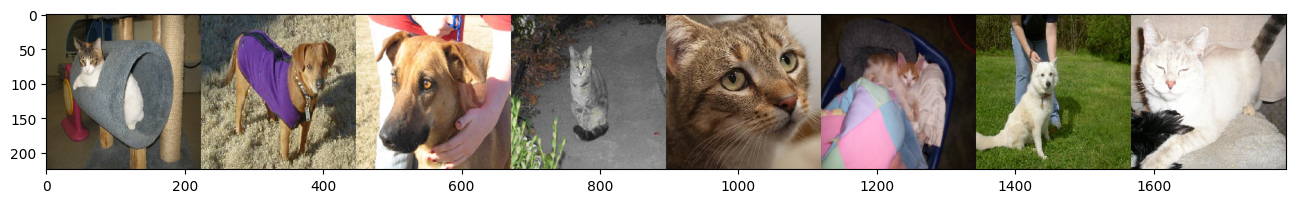

In [24]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [25]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                  

In [26]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
3/3 [==============================] - 16s 4s/step - loss: 0.7459 - accuracy: 0.4911 - val_loss: 0.7022 - val_accuracy: 0.4667
Epoch 2/10
3/3 [==============================] - 15s 4s/step - loss: 0.6952 - accuracy: 0.4947 - val_loss: 0.6952 - val_accuracy: 0.4333
Epoch 3/10
3/3 [==============================] - 15s 4s/step - loss: 0.6871 - accuracy: 0.5765 - val_loss: 0.6931 - val_accuracy: 0.5667
Epoch 4/10
3/3 [==============================] - 14s 4s/step - loss: 0.6843 - accuracy: 0.6157 - val_loss: 0.6939 - val_accuracy: 0.4833
Epoch 5/10
3/3 [==============================] - 14s 4s/step - loss: 0.6707 - accuracy: 0.6263 - val_loss: 0.6912 - val_accuracy: 0.5833
Epoch 6/10
3/3 [==============================] - 15s 4s/step - loss: 0.6634 - accuracy: 0.6441 - val_loss: 0.6982 - val_accuracy: 0.6167
Epoch 7/10
3/3 [==============================] - 14s 4s/step - loss: 0.6312 - accuracy: 0.6940 - val_loss: 0.7297 - val_accuracy: 0.5000
Epoch 8/10
3/3 [==================

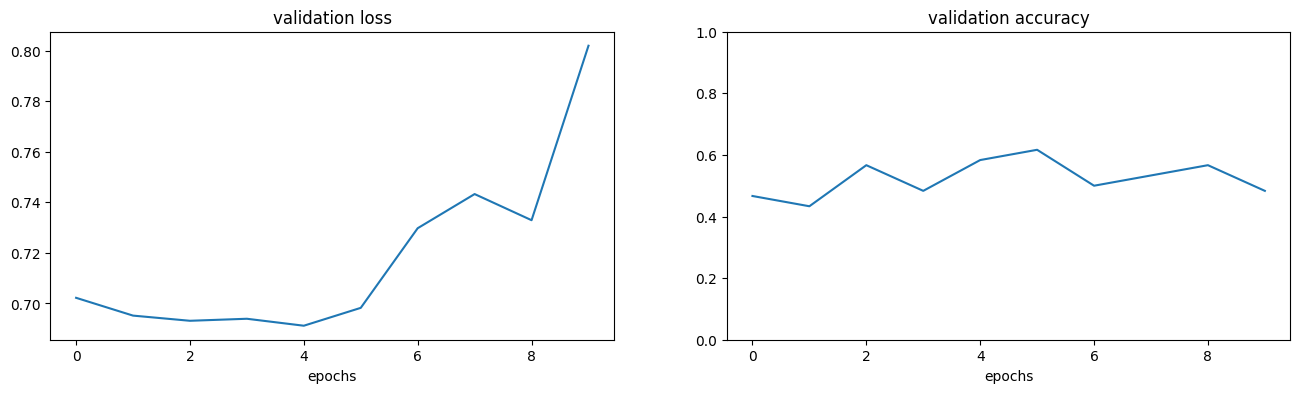

In [27]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [28]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6067240834236145
Test accuracy: 0.6065573692321777


In [29]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [30]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [31]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [32]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
3/3 [==============================] - 71s 22s/step - loss: 1.1317 - accuracy: 0.4947 - val_loss: 0.6857 - val_accuracy: 0.5667
Epoch 2/10
3/3 [==============================] - 69s 22s/step - loss: 0.8353 - accuracy: 0.5374 - val_loss: 0.6338 - val_accuracy: 0.6167
Epoch 3/10
3/3 [==============================] - 69s 22s/step - loss: 0.6051 - accuracy: 0.6406 - val_loss: 0.8867 - val_accuracy: 0.4667
Epoch 4/10
3/3 [==============================] - 68s 22s/step - loss: 0.7212 - accuracy: 0.5160 - val_loss: 0.6142 - val_accuracy: 0.6000
Epoch 5/10
3/3 [==============================] - 68s 22s/step - loss: 0.6346 - accuracy: 0.6192 - val_loss: 0.5542 - val_accuracy: 0.6833
Epoch 6/10
3/3 [==============================] - 69s 22s/step - loss: 0.5116 - accuracy: 0.7829 - val_loss: 0.6634 - val_accuracy: 0.5167
Epoch 7/10
3/3 [==============================] - 69s 22s/step - loss: 0.5537 - accuracy: 0.6370 - val_loss: 0.4963 - val_accuracy: 0.7667
Epoch 8/10
3/3 [===========

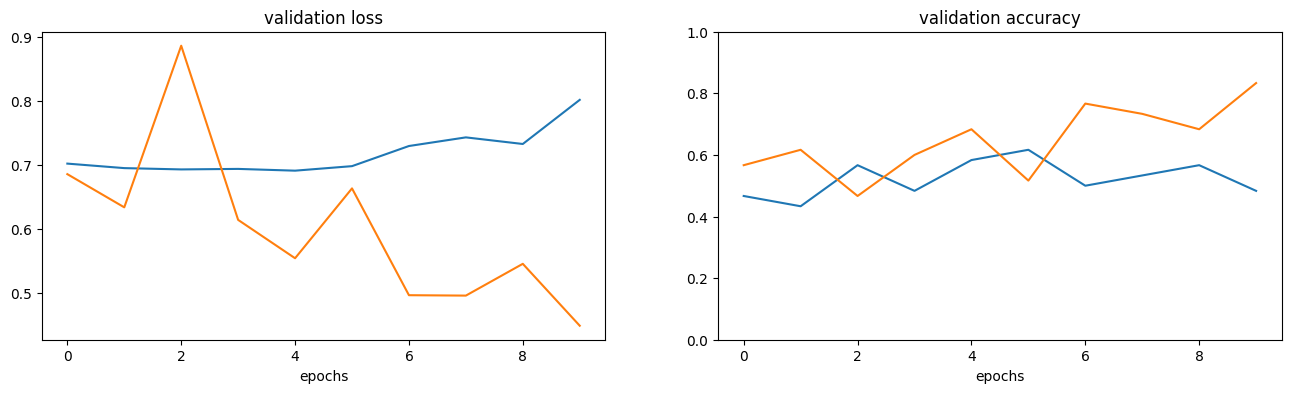

In [33]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"]) #modificado novamente
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [34]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.4319145977497101
Test accuracy: 0.8032786846160889


In [36]:
img, x = get_image('/content/drive/MyDrive/amostras/gato/1.jpg')
probabilities = model_new.predict([x])
print(probabilities)
np.argmax(probabilities,axis=1)

1/1 [==============================] - 1s 773ms/step
[[6.8808417e-06 9.9999309e-01]]


array([1])